In [97]:
%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw as imd

im = cv.imread(r'C:\Users\user\Downloads\combine.png')

In [91]:
def is_int (num):
    if (abs(num)%2==0 or (abs(num)+1)%2==0):
        return True
    else :
        return False

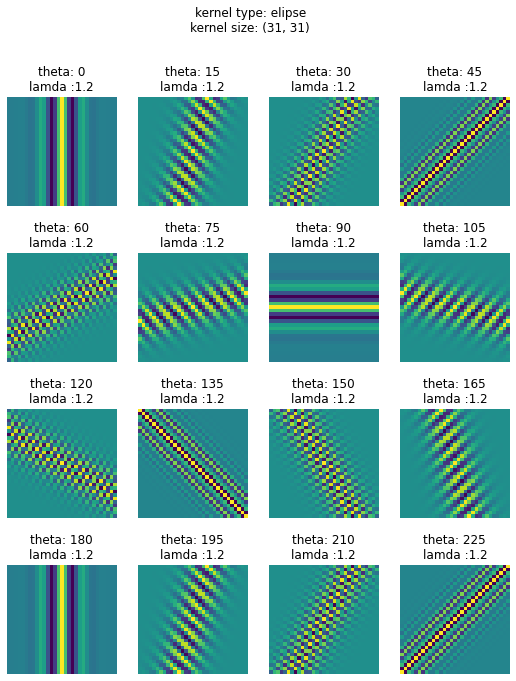

In [92]:
def kernel_builder(k=11,gamma=1,lamda='var'):
    
    if k%2==0:
        k=k+1
    if is_int(gamma):
        kernel_type ='circle'
    else:
        kernel_type= 'elipse'
    
    #thetas =np.full(16,np.pi)
    thetas=np.arange(0, 5*np.pi/4, np.pi/12)
    
    if lamda=='var':
        lamdas = np.linspace(np.pi/2, np.pi+2, 16)    
    else :
        lamdas = np.full(16,lamda)
    
    f,ax =plt.subplots(4,4, figsize=(9,11))
    
    kernels =[]
      
    for lam,theta,axs in zip(lamdas,thetas, ax.flatten()):
        kern = cv.getGaborKernel((k,k), sigma=4.0, theta=theta, lambd=lam,psi=0,gamma=gamma, ktype=cv.CV_32F)
        kernels.append(kern)
               
        axs.imshow(kern)
        axs.set_title('theta: {:.0f}\nlamda :{:.1f}'.format(theta*180/np.pi,lam))
        axs.axis('off')

    f.suptitle('kernel type: {}\nkernel size: {}'.format(kernel_type,(k,k)))
    f.set_tight_layout(False)
    #f.savefig(fname =r'C:\Users\user\Documents\kernels_{}_{}_lamda_{}.png'.format(k,kernel_type,lamda),format= 'png')
    return f,kernels,kernel_type,thetas,lamdas,lamda,gamma

sheet, kernels,k_type,thetas,lamdas,l_type,gamma = kernel_builder(k=31,gamma=0.01,lamda=1.2)

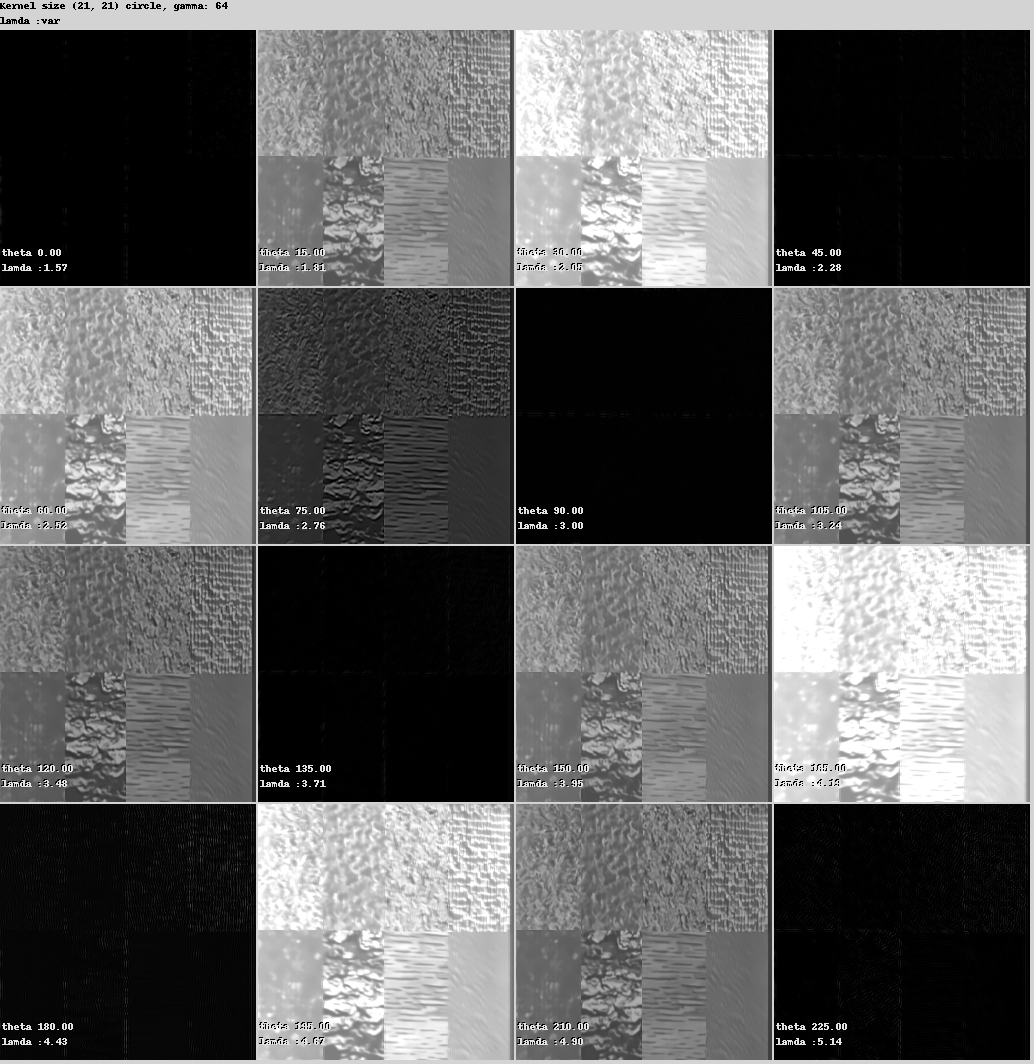

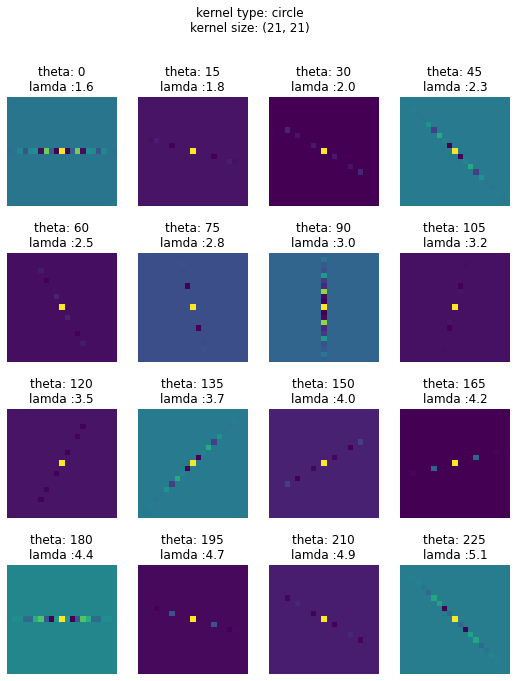

In [100]:
def compare_kernels(im,kernels,k_type,thetas,lamdas,l_type,gamma):
    
    from PIL import ImageDraw as imd
    from PIL import Image
    gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
    dst = cv.fastNlMeansDenoising(gray,None,10,7,21)
    filtered_im = []
    canvas = Image.new('L', (256*4+10,256*4+40),'lightgray')
    x,y =0,30
    k=kernels[0].shape[0]
    imd.Draw(canvas).text((0,0),'Kernel size {} {}, gamma: {} \nlamda :{}'.format((k,k),k_type,gamma,l_type), 
                            fill='black', stroke_width=0,stroke_fill='black')
    
    for kernel,teta,lamda in zip(kernels,thetas,lamdas):
        fimg = cv.filter2D(dst, cv.CV_8UC3, kernel)
        filtered_im.append(fimg)
        fimg = Image.fromarray(fimg).reduce(2)
        imd.Draw(fimg).text((1,fimg.height-40),'theta {:.2f}\nlamda :{:.2f}'.format(teta*180/np.pi,lamda), 
                            fill='yellow', stroke_width=1,stroke_fill='black')
        canvas.paste(fimg,(x,y))
        if (x+fimg.width)>1024:
            x = 0
            y = y + fimg.height + 2
            
        else: x = x + fimg.width + 2
        
        #canvas.save(r'C:\Users\user\Documents\combine_{}_{}_lamda_{}_gama_{}.png'.format(k_type,k,l_type,gamma),format='png')
    return canvas, filtered_im

sheet, kernels,k_type,thetas,lamdas,l_type,gamma = kernel_builder(k=21,gamma=64)
cvas,filts = compare_kernels(im,kernels,k_type,thetas,lamdas,l_type,gamma)
cvas


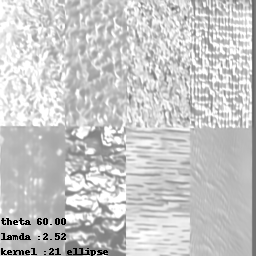

In [162]:
def apply_Gabor(im,k=7,theta=0,lamda=0,gamma=1):
    
    from PIL import ImageDraw as imd
    from PIL import Image
    
    
    theta=theta*np.pi/180
    
    kern = cv.getGaborKernel((k,k), sigma=4.0, theta=theta, lambd=lamda,psi=0,gamma=gamma, ktype=cv.CV_32F)
    gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
    dst = cv.fastNlMeansDenoising(gray,None,10,7,21)
    fimg = cv.filter2D(dst, cv.CV_8UC3, kern)
    fimg = Image.fromarray(fimg).reduce(2)
    imd.Draw(fimg).text((1,fimg.height-40),'theta {:.2f}\nlamda :{:.2f}\nkernel :{} ellipse'.format(theta*180/np.pi,lamda,k),
                        fill='black', stroke_width=0,stroke_fill='gray')
    #fimg.save(r'C:\Users\user\Documents\combined_filtered.png',format='png')
    return fimg
apply_Gabor(im,k=21,theta=60,lamda=2.52,gamma=36)

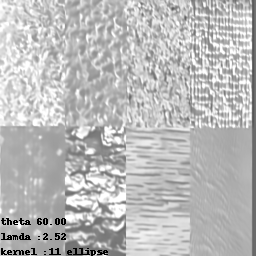

In [163]:
apply_Gabor(im,k=11,theta=60,lamda=2.52,gamma=36)

### Inferences based on evaluation of Gabor kernels on the two images


#### Preprocessing
The images were converted to grayscale and denoised before the kernels were applied.

#### Kernel size
As size of kernel increases the band filters restrict more features from the image to pass through it. For lower values of kernel the filters are lenient to image features. This behaves analogous to the pore size in filters with higher values indicating smaller pore size.

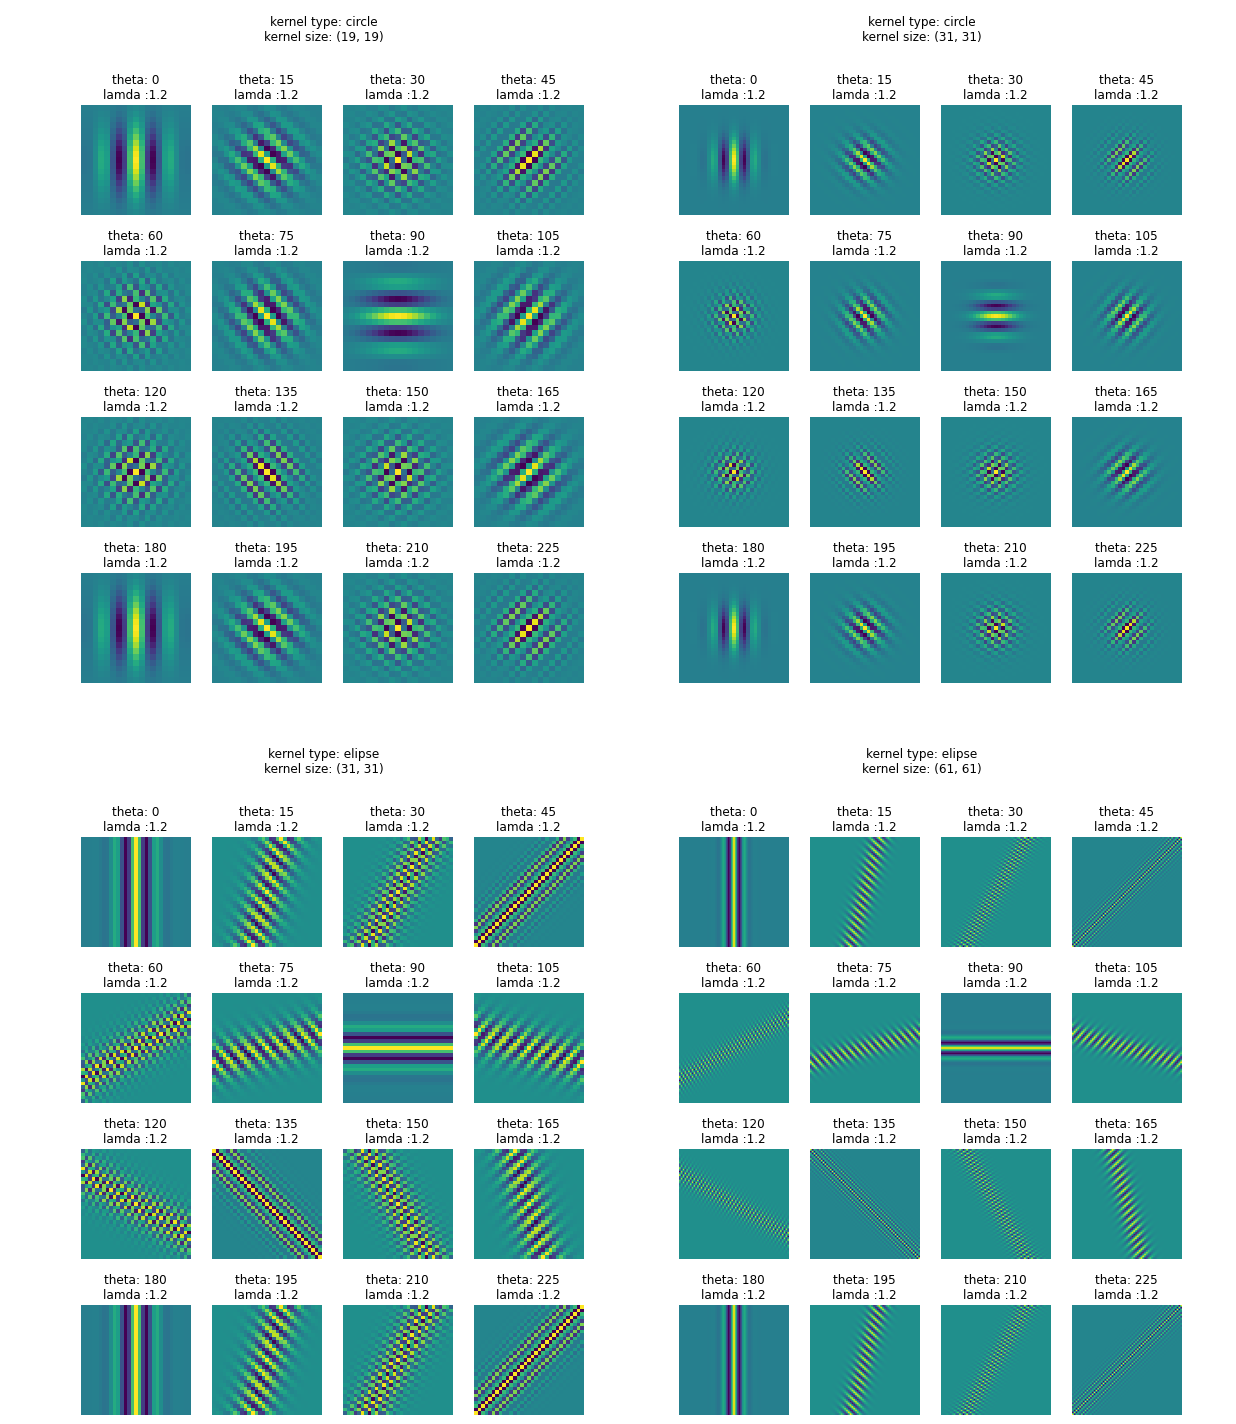

The kernel size appears to have a strong dependence on theta, where the general rule of having tighter control over pixel values that can pass through the filter with increasing kernel size is relaxed for certain angles. This can be seen in the wood ring image where changing the kernel from 19x19 to 21x21 produces brighter images for angle, theta 90 and 120 dgrees.
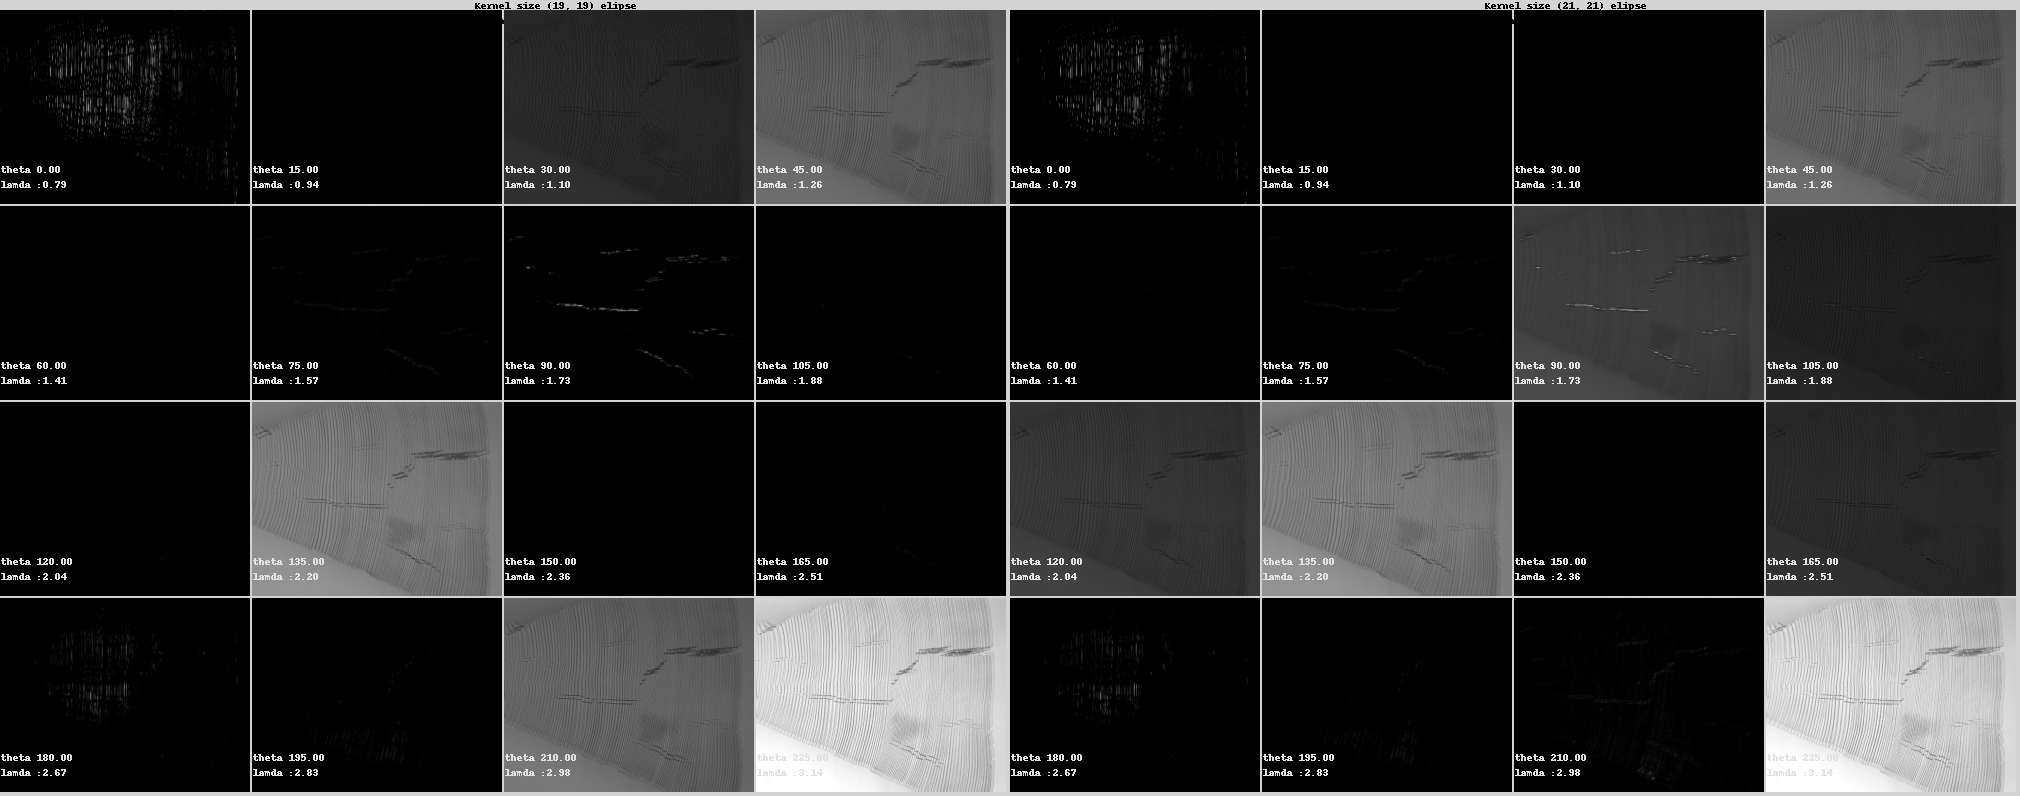


#### Lamda
Increasing the value of wavelength parameter lamda sharpens the filter and applies a stronger threshold for pixel brightness. From experimenting with different values for lambda, theta and kernel size on the wood graving image, the following combination of the parameters displayed on the filtered image was visually verified to be optimal.
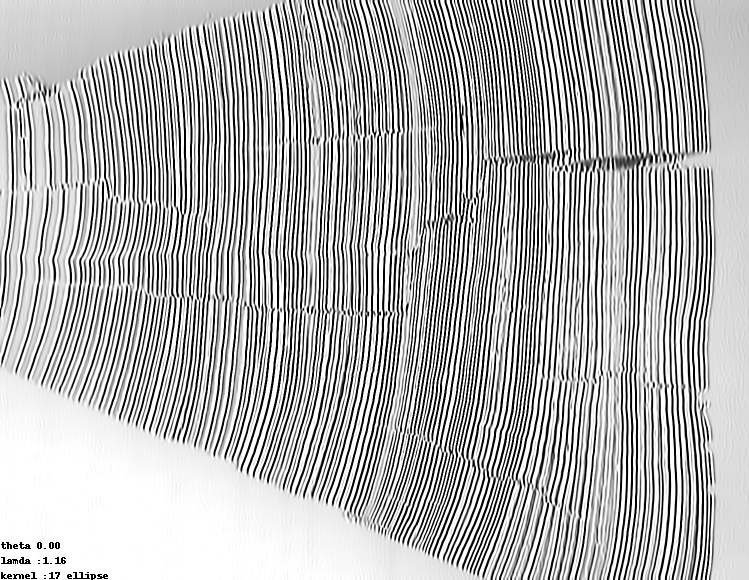

#### Gamma
Using eliptical kernel (gamma in non perfect squares) produces images with better contrast compared to circular orbits(perfect squares values for gamma).

The gama parameter tunes the average brightness to form smoother thresholding as we increase its value, across all possible combinations of the other parameters. As can be seen in the images below:

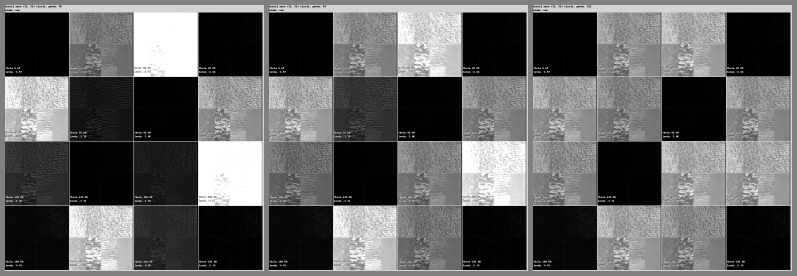


However at higher values of gamma for a given kernel size, the filter appears to normalize the brightness levels across all possible angles. At higher gamma, kernel angles with strongly filtereing values allow more pixels to pass through it and kernel angles which had earlier higher brightness are less bright. 

#### Results
Based on the investigation of the effects the different parameters of the gabor filter had on the image under consideration, the parameters mentioned on the image below produced the most optimal result for the cluster image as examined visually:
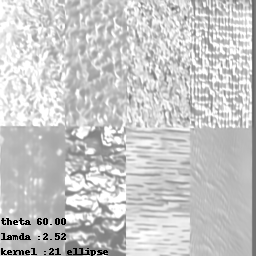

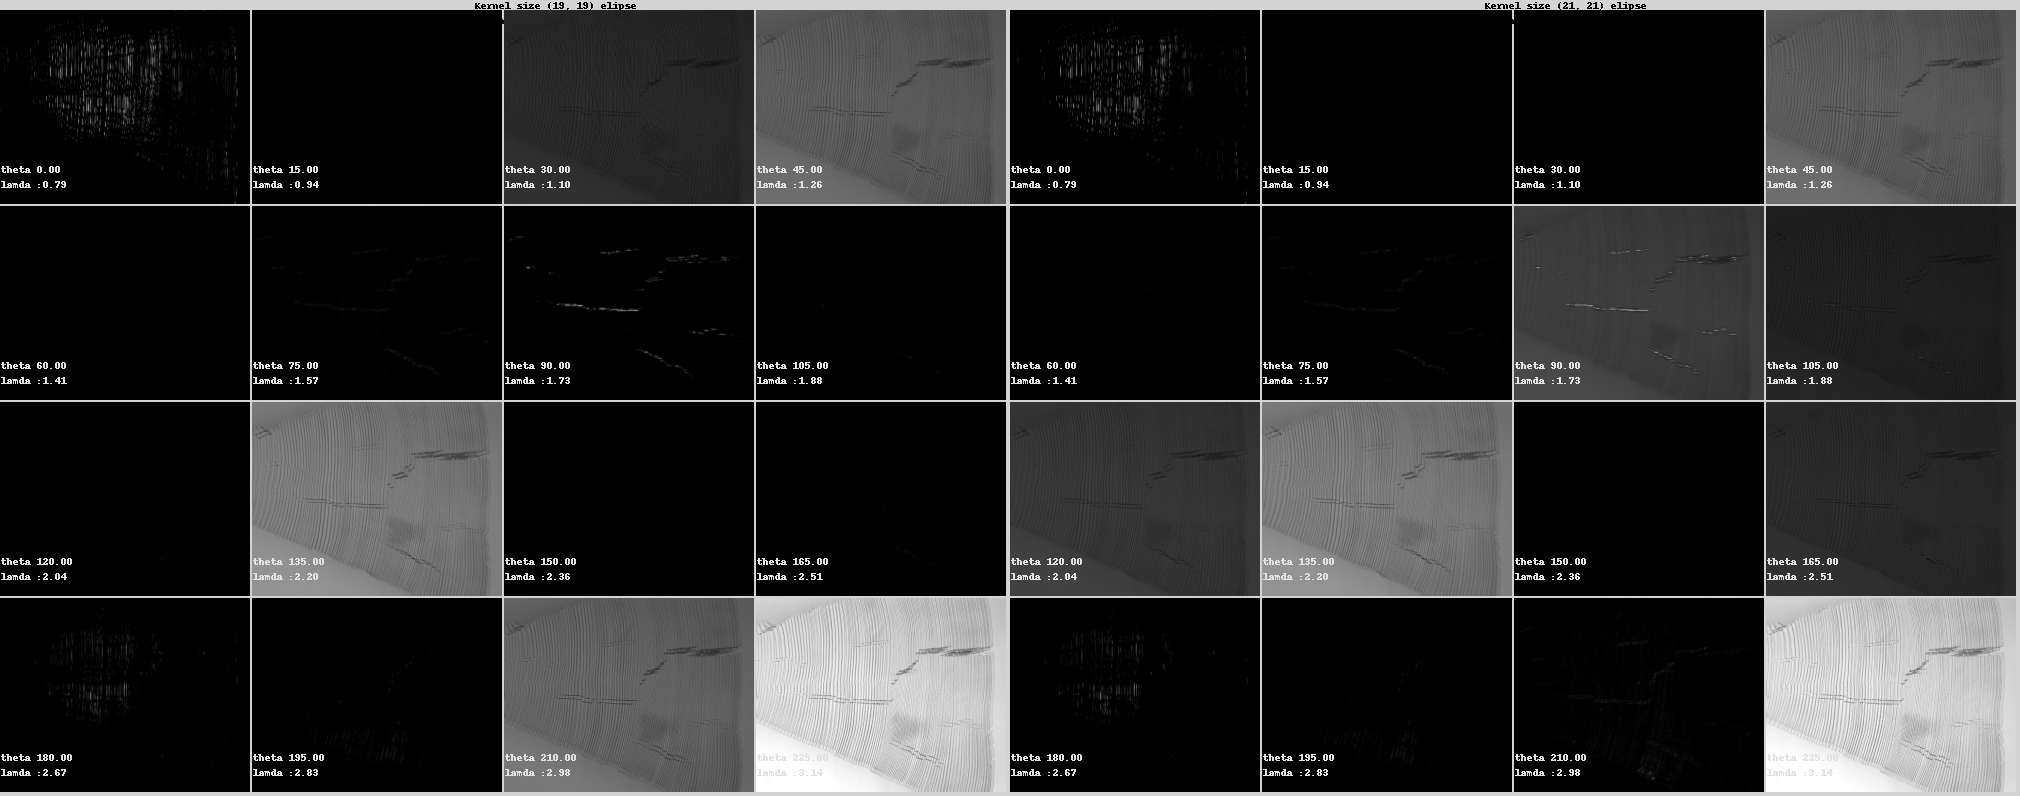

In [169]:
def print_canvas(im, reduction,cols,rows):
    
    width = im[0].reduce(reduction).width
    height = im[0].reduce(reduction).height
    sheet = Image.new('RGB', (width*cols,height*rows),'grey')
    x =0
    y = 0
    
    for img in im:
        sheet.paste(img.reduce(reduction),(x,y))
        x = x+width
        if x > width:
            x=0
            y+=height


    sheet
    #sheet.save(r'C:\Users\user\Documents\lamda_anomaly_for90_120.png',format='png')
    return sheet

names = ['wood_elipse_19_lamda_var.png','wood_elipse_21_lamda_var.png']
path = r'C:\Users\user\Documents'
im = [Image.open(path + '\{}'.format(i)) for i in names]

print_canvas(im,1,2,1)